<a href="https://colab.research.google.com/github/OstroPolli/Portfolio/blob/main/RFM_pharmacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM analysis of pharmacy chain clients #

**Goal**
- to find out which customer groups predominate in our database  
- suggest communication strategies with clients based on their characteristics  

## Loading and preprocessing ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [2]:
df= pd.read_csv(
    'https://gist.githubusercontent.com/andron23/f73a19243564d80a388db2b7b1542fd2/raw/2479b4326f6c8ae13d06060fb8510d04bcf06113/apteka.csv',
    sep=';'
)

In [3]:
df.head()

,datetime,shop,card,bonus_earned,bonus_spent,summ,summ_with_disc,doc_id
0,2021-07-13 12:56:09.000,Аптека 2,2000200195023,51,0,3400,3400,15#2002741#65938#2_29
1,2021-07-30 10:42:00.000,Аптека 2,2000200193494,57,0,747,747,15#2002972#65955#2_5
2,2021-10-11 12:55:23.000,Аптека 2,2000200199106,92,253,3077,3077,15#2004060#66028#2_29
3,2021-10-14 14:48:56.000,Аптека 2,2000200168768,1,0,54,54,15#2004107#66031#2_57
4,2021-10-20 11:09:39.000,Аптека 2,2000200226314,101,0,1733,1733,15#2004192#66037#2_16


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38486 entries, 0 to 38485
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   datetime        38486 non-null  object
 1   shop            38486 non-null  object
 2   card            38486 non-null  object
 3   bonus_earned    38486 non-null  int64 
 4   bonus_spent     38486 non-null  int64 
 5   summ            38486 non-null  int64 
 6   summ_with_disc  38486 non-null  int64 
 7   doc_id          38486 non-null  object
dtypes: int64(4), object(4)
memory usage: 2.3+ MB


Datetime is object so we need to convert it into Date format.

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df.isna().sum()

datetime          0
shop              0
card              0
bonus_earned      0
bonus_spent       0
summ              0
summ_with_disc    0
doc_id            0
dtype: int64

In [7]:
df.duplicated().mean()

0.0

There are no missing values and duplicates.

We know, that correct card numbers start from '2000', other numbers and mix of symbols are auto-answer of cash mashine in offline mode. Therefore we need to keep data only with correct card numbers.

In [8]:
df = df[df['card'].str.startswith('2000')]

In [9]:
df.shape

(21075, 8)

In [10]:
print(f'We deleted {round((38486-21075)/38486*100, 1)}% of data')

We deleted 45.2% of data


In [11]:
df = df.sort_values(['card', 'datetime'])
df.head()

,datetime,shop,card,bonus_earned,bonus_spent,summ,summ_with_disc,doc_id
641,2021-07-19 09:37:20,Аптека 2,2000200150015,0,1,21,21,15#2002822#65944#2_6
16455,2021-12-07 20:25:21,Аптека 2,2000200150022,30,0,1351,1351,15#2004825#66085#2_140
8751,2021-10-05 16:31:25,Аптека 2,2000200150053,15,0,649,649,15#2003981#66022#2_65
28718,2022-03-17 20:50:23,Аптека 7,2000200150053,1,0,64,64,15#11002624#66185#11_177
834,2021-07-21 11:10:25,Аптека 2,2000200150091,22,0,746,746,15#2002857#65946#2_4


## Preparing data for RFM analysis ##

Preparing data for RFM analysis. Count total sum of spendigs of customers(Monetary), amount of purchases(Frequency) and amount of days since last purchase(Recency).  
In our case we use the last datetime of database as day of research.

In [12]:
dfrfm = df.groupby('card').agg(
    ttl_sum = ('summ','sum'),
    purchases = ('card', 'count'),
    last_purchase = ('datetime', 'last')
).reset_index()

In [13]:
dfrfm.head()

,card,ttl_sum,purchases,last_purchase
0,2000200150015,21,1,2021-07-19 09:37:20
1,2000200150022,1351,1,2021-12-07 20:25:21
2,2000200150053,713,2,2022-03-17 20:50:23
3,2000200150091,3549,5,2022-06-05 11:49:47
4,2000200150107,1735,3,2022-06-02 17:54:19


In [14]:
#counting amount of days since time of reaserch
dfrfm['days_purchase'] = (max(df['datetime']) - dfrfm['last_purchase']).dt.days
dfrfm = dfrfm.drop('last_purchase', axis=1)

In [15]:
dfrfm.head()

,card,ttl_sum,purchases,days_purchase
0,2000200150015,21,1,325
1,2000200150022,1351,1,184
2,2000200150053,713,2,84
3,2000200150091,3549,5,4
4,2000200150107,1735,3,7


### Exploring boundary values to divide each characteristic into groups ###

In [16]:
#prepare percentiles to check the data distribution
quantiles = [round(el,2) for el in np.arange(0.1, 1.1, 0.1)]
quantiles

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#### Monetary boundaries ####

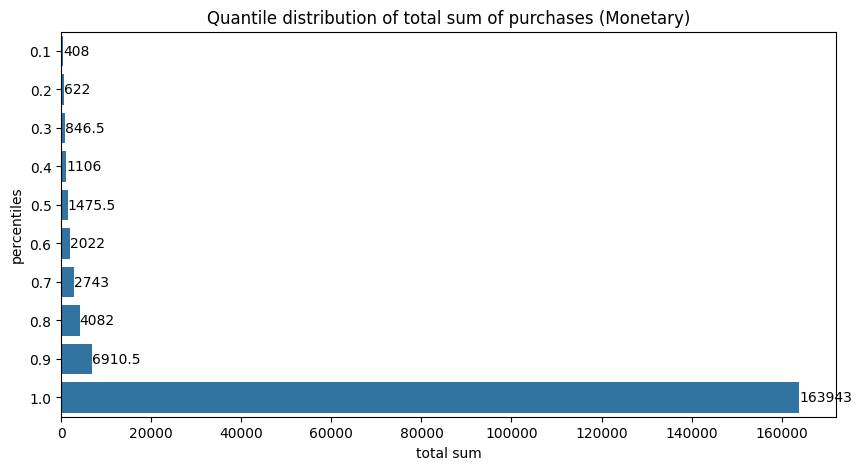

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(dfrfm['ttl_sum'].quantile(quantiles),
                 orient='h')
ax.set(
    xlabel="total sum",
    ylabel="percentiles",
    title="Quantile distribution of total sum of purchases (Monetary)"
)
ax.bar_label(ax.containers[-1])
plt.show();

For monetary boundries we will use division based on 0.33 and 0.66 quantiles.  


#### Frequency boundaries ####

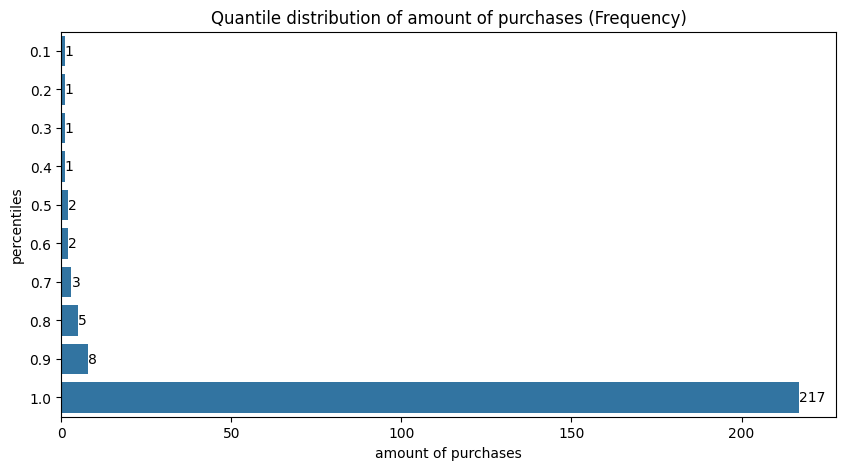

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(dfrfm['purchases'].quantile(quantiles),
                 orient='h')
ax.set(
    xlabel="amount of purchases",
    ylabel="percentiles",
    title="Quantile distribution of amount of purchases (Frequency)"
)
ax.bar_label(ax.containers[-1])
plt.show();

In [19]:
dfrfm['purchases'].quantile([0.45, 0.85])

0.45    1.0
0.85    6.0
Name: purchases, dtype: float64

In [20]:
dfrfm[dfrfm['purchases'] < 2].shape[0]

2686

In [21]:
dfrfm[(dfrfm['purchases'] > 1) & (dfrfm['purchases'] < 6)].shape[0]

2311

In [22]:
dfrfm[dfrfm['purchases'] > 6].shape[0]

759

For Frequency we will use 0.46 and 0.85 quantiles as boundaries of groups, because we want to get 1-purchase clients in seperate group and clients, who made more then 5 purchases we put in the group '3' - most active buyers

#### Recency boundaries ####

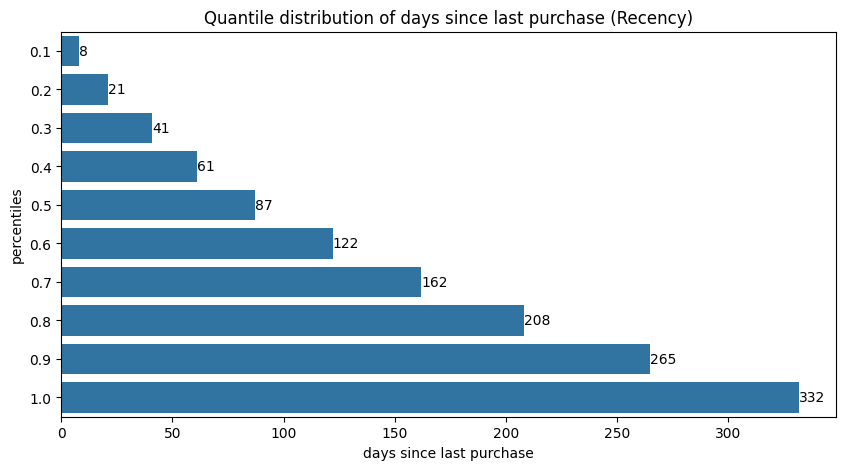

In [23]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(dfrfm['days_purchase'].quantile(quantiles),
                 orient='h')
ax.set(
    xlabel="days since last purchase",
    ylabel="percentiles",
    title="Quantile distribution of days since last purchase (Recency)"
)
ax.bar_label(ax.containers[-1])
plt.show();

For recency boundries we will use division based on 0.33 and 0.66 quantiles.  


### Assign scores ​​to features ###

Create a function to set scores for values in RFM features.

In [24]:
def set_score(val, var, quant_1, quant_2): #get value, feature and two boarder quantiles
  if val < quant_1:
    return 1 if var != 'R' else 3
  elif quant_1 < val < quant_2:
    return 2
  else:
    return 3 if var != 'R' else 1

In [25]:
recency_quantiles = dfrfm['days_purchase'].quantile([0.33, 0.66])
dfrfm['R'] = dfrfm['days_purchase'].apply(set_score, args=('R', recency_quantiles.iloc[0], recency_quantiles.iloc[1]))

frequency_quantiles = dfrfm['purchases'].quantile([0.46, 0.85])
dfrfm['F'] = dfrfm['purchases'].apply(set_score, args=('F', frequency_quantiles.iloc[0], frequency_quantiles.iloc[1]))

monetary_quantiles = dfrfm['ttl_sum'].quantile([0.33, 0.66])
dfrfm['M'] = dfrfm['ttl_sum'].apply(set_score, args=('M', monetary_quantiles.iloc[0], monetary_quantiles.iloc[1]))

In [26]:
dfrfm = dfrfm[['card', 'days_purchase', 'purchases', 'ttl_sum', 'R',	'F', 'M']]

Join scores from R, F, M columns in one 'rfm'.

In [27]:
dfrfm.loc[:, 'rfm'] = dfrfm[['R', 'F', 'M']].astype(str).agg(''.join, axis=1)

<ipython-input-27-fa1d3430f8bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrfm.loc[:, 'rfm'] = dfrfm[['R', 'F', 'M']].astype(str).agg(''.join, axis=1)


In [28]:
dfrfm.head(10)

,card,days_purchase,purchases,ttl_sum,R,F,M,rfm
0,2000200150015,325,1,21,1,1,1,111
1,2000200150022,184,1,1351,1,1,2,112
2,2000200150053,84,2,713,2,3,1,231
3,2000200150091,4,5,3549,3,2,3,323
4,2000200150107,7,3,1735,3,2,2,322
5,2000200150138,226,1,129,1,1,1,111
6,2000200150145,21,14,12426,3,3,3,333
7,2000200150176,302,1,1192,1,1,2,112
8,2000200150190,165,1,2327,1,1,2,112
9,2000200150237,45,3,2772,3,2,3,323


## RFM analysis ##

### RFM segments ###

Distribution of clients by basic RFM segments.

In [29]:
rfm = dfrfm.groupby('rfm')['card'].count().reset_index().sort_values(by='card', ascending=False)
rfm.head(10)

,rfm,card
0,111,801
26,333,666
9,211,438
1,112,430
18,311,324
17,233,314
10,212,281
23,323,262
14,223,250
13,222,199


In [30]:
fig = px.treemap(rfm, path=['rfm'], values='card')
fig.update_layout(title='RFM segments')
fig.show()

We see, that the biggest segment is '111' consists of clients, who have not contributed financially to the business and who stoped buying quite ago.  
However, it's noteworthy that our top-performing clients, classified as '333', also constitute a significant portion of our customer base, ranking second in size.

### Customer segments ###

Distribution of clients by typical segments.

In [31]:
#chage type of data to use function
dfrfm['rfm'] = dfrfm['rfm'].astype('int64')

Wright a function to assign segment name to cleint based on rfm segment values.

In [32]:
def segments_kind(data):
  if data in [123, 133, 213,223,233, 323]:
    return 'Big Spender'
  elif data in [121, 112, 131, 113, 122, 221, 222]:
    return 'Lost Customer'
  elif data == 333 :
    return 'Best Customer'
  elif data in [212, 313, 312, 322]:
    return 'New Spender'
  elif data in [111, 211, 311, 321]:
    return 'DeadBeat'
  else: return 'Loyal Customer'

In [33]:
dfrfm['segment'] = dfrfm['rfm'].apply(segments_kind)

In [34]:
dfrfm.head(10)

,card,days_purchase,purchases,ttl_sum,R,F,M,rfm,segment
0,2000200150015,325,1,21,1,1,1,111,DeadBeat
1,2000200150022,184,1,1351,1,1,2,112,Lost Customer
2,2000200150053,84,2,713,2,3,1,231,Loyal Customer
3,2000200150091,4,5,3549,3,2,3,323,Big Spender
4,2000200150107,7,3,1735,3,2,2,322,New Spender
5,2000200150138,226,1,129,1,1,1,111,DeadBeat
6,2000200150145,21,14,12426,3,3,3,333,Best Customer
7,2000200150176,302,1,1192,1,1,2,112,Lost Customer
8,2000200150190,165,1,2327,1,1,2,112,Lost Customer
9,2000200150237,45,3,2772,3,2,3,323,Big Spender


In [35]:
segm = dfrfm['segment'].value_counts().reset_index()
segm['%'] = round(segm['segment'] / segm['segment'].sum() *100, 1)
segm

,index,segment,%
0,DeadBeat,1595,26.9
1,Big Spender,1200,20.2
2,Lost Customer,1004,16.9
3,Loyal Customer,765,12.9
4,New Spender,696,11.7
5,Best Customer,666,11.2


In [36]:
dfrfm[['segment','rfm', 'card']].groupby(['segment','rfm']).count().reset_index().sort_values(by=['segment','card'],ascending=[True,False])

,segment,rfm,card
0,Best Customer,333,666
5,Big Spender,233,314
6,Big Spender,323,262
4,Big Spender,223,250
1,Big Spender,123,153
2,Big Spender,133,136
3,Big Spender,213,85
7,DeadBeat,111,801
8,DeadBeat,211,438
9,DeadBeat,311,324


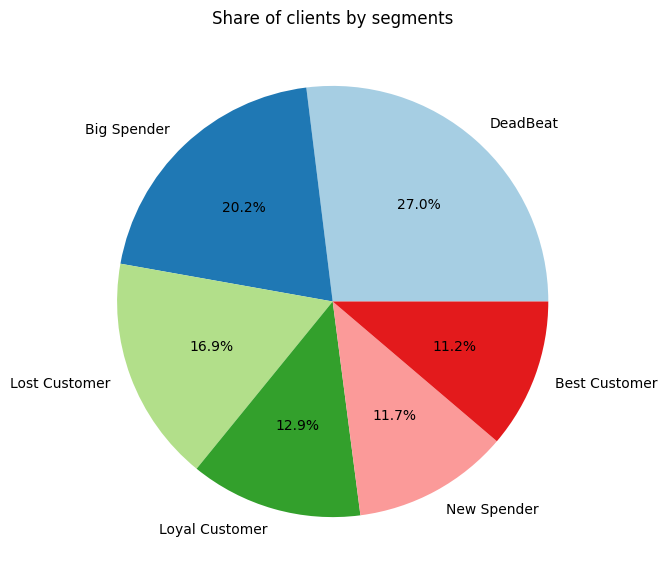

In [37]:
plt.figure(figsize=(7, 7))
plt.pie(x=segm['%'], labels=segm['index'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Share of clients by segments')
plt.show();

In [38]:
fig = px.treemap(segm, path=['index'], values='segment', labels='segment')
fig.update_layout(title='Segments of customers')
fig.show();

After grouping rfm segments into marketing segments, we've noticed that 'DeadBeats' became the largest segment of our clients base, comprising 26.9% of the database. And "Best Clients" are ranked last, accounting for only 11.2% of the total base.

### Suggestions for marketing activities for segments ##

**DeadBeats**  

*clients, who used to duy for a small sum and made it rare and mostly a lot of time ago*  

This category has a low potential to return. They are in the last priority for marketing investments.

**Big Spenders**  

*clients, who spend big sums of money in our pharmacy*  

This customers not realy worry about low prices and discounts. For them we can suggest
- complimentary goods
- some new items and best sellers of non-medical product line

**Lost Customers**  

*clients, who for some reasons stopped buying at us*  

We need to try to bring them back with help of:
- discount and special offer
- present, which can get during next purchase

**Loyal Customers**  

*clients, who frequently come to our pharmacy chain and make regular purchases, but they are not 'Big Spenders' and their total spending not very high*  

Customers, who depends on pharmacy. They can be in the process of treatment and need regular medication.  
- they can be more interested low price, so we can offer special offers, like 2=1
- also they can be interested in health supporting products: vitamins,
probiotics, patches etc  

We can try to stimulate them to become "Big Spenders". For example we can:
- give a discount after reaching special check amount
- make an opportunity to choose "good of month", which he\she buy regulary, to get a discount on it

**New Spenders**  

*new clients, who came recently and didn't have time to repurchase, but they spent not the smallest amount of money in our pharmacy chain*  

We can try stimulate this group to come again to us by:
- giving a discount for newcommers
- involving in bonus system and give bonuses for registration, which can be used to pay for next purchase

**Best Customers**  

*best clients, who spend a lot of money, buy frequently and was recently in our pharmacy*  

We need to keep them with us and make maximume loyal to us. This clients can be our ambassadors. For them we can make some VIP privilegies:
- buying in pharmacy without queue  
- cross promo with discounts to partners
- samples \ promo sets of some goods